In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

# for data leveling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# for aumentation
from scipy.ndimage import rotate

In [8]:
# define ouput dir
output_dir = Path("../output/XGBoost")
output_dir.mkdir(parents=True, exist_ok=True)

output_img_dir = output_dir / "IMG"
output_img_dir.mkdir(parents=True, exist_ok=True)

output_model_dir = output_dir / "model"
output_model_dir.mkdir(parents=True, exist_ok=True)

In [9]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, green):
    return (nir - green) / (nir + green + 1e-10)

# define data augmentation function
def augment_image(bands):
    """Perform augmentation on GeoTIFF bands (NIR, Red, Green)."""
    nir, red, green = bands[3], bands[0], bands[1]

    aug_bands = []
    # original
    aug_bands.append((nir, red, green))

    # Rotations (60,120,180, 240, 300) - keep shape same
    for angle in [60, 120, 180, 240, 300]:
        aug_bands.append((
            rotate(nir, angle, reshape=False),
            rotate(red, angle, reshape=False),
            rotate(green, angle, reshape=False)
        ))

    # Horizontal + vertical flips
    aug_bands.append((np.fliplr(nir), np.fliplr(red), np.fliplr(green)))
    aug_bands.append((np.flipud(nir), np.flipud(red), np.flipud(green)))

    # Small Gaussian noise (simulate sensor variation)
    noise = np.random.normal(0, 0.01, nir.shape).astype(nir.dtype)
    aug_bands.append((nir + noise, red + noise, green + noise))

    return aug_bands

'''
    Enhanced Feature Engineering:
        -  Current features (mean NDVI/NDWI) might be insufficient. Add:

'''
def extract_features(image_path, augment=False):
    with rasterio.open(image_path) as src:
        bands = src.read()

    feature_set = []
    band_sets = augment_image(bands) if augment else [(bands[3], bands[0], bands[1])]

    for nir, red, green in band_sets:
        # NDVI / NDWI
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, green)

        # Feature vector
        features = [
            np.mean(ndvi), np.std(ndvi),
            np.mean(ndwi), np.std(ndwi),
            np.percentile(nir, 75),
            np.mean(green > np.quantile(green, 0.75))
        ]
        feature_set.append(features)

    return feature_set


In [10]:
# Load dataset efficiently
train_dataset_path = Path('../../../../data/odm_dataset/Patches/Train')
test_dataset_path = Path('../../../../data/odm_dataset/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        feats = extract_features(img_path, augment=True)  # enable augmentation
        for f in feats:
            X.append(f)
            y.append(idx)

X = np.array(X)
y = np.array(y)

# ADD SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        feats = extract_features(img_path, augment=False)  # no augmentation
        for f in feats:   # usually only 1 feature vector
            X_test.append(f)
            y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [07:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.25, 'max_depth': 5, 'reg_lambda': 1}
Best Cross-Validation Accuracy: 0.9366
[0]	validation_0-mlogloss:1.14245	validation_1-mlogloss:1.18518
[1]	validation_0-mlogloss:0.98517	validation_1-mlogloss:1.06093
[2]	validation_0-mlogloss:0.87204	validation_1-mlogloss:0.96981
[3]	validation_0-mlogloss:0.78974	validation_1-mlogloss:0.90583
[4]	validation_0-mlogloss:0.72563	validation_1-mlogloss:0.85460
[5]	validation_0-mlogloss:0.67490	validation_1-mlogloss:0.82044
[6]	validation_0-mlogloss:0.63173	validation_1-mlogloss:0.78386
[7]	validation_0-mlogloss:0.59658	validation_1-mlogloss:0.75740
[8]	validation_0-mlogloss:0.56780	validation_1-mlogloss:0.74193
[9]	validation_0-mlogloss:0.54234	validation_1-mlogloss:0.72572
[10]	validation_0-mlogloss:0.51895	validation_1-mlogloss:0.70938
[11]	validation_0-mlogloss:0.49973	validation_1-mlogloss:0.69910
[12]	validation_0-mlogloss:0.48525	validation_1-mlogloss:0.69217
[13]	validation_0-mlogloss:0.46994	validation_1-mlog

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [07:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-mlogloss:0.35767	validation_1-mlogloss:0.65506
[28]	validation_0-mlogloss:0.35198	validation_1-mlogloss:0.65380
[29]	validation_0-mlogloss:0.34757	validation_1-mlogloss:0.65419
[30]	validation_0-mlogloss:0.34165	validation_1-mlogloss:0.65457
[31]	validation_0-mlogloss:0.33594	validation_1-mlogloss:0.65431
[32]	validation_0-mlogloss:0.33040	validation_1-mlogloss:0.65339
[33]	validation_0-mlogloss:0.32729	validation_1-mlogloss:0.65497
[34]	validation_0-mlogloss:0.32327	validation_1-mlogloss:0.65748
[35]	validation_0-mlogloss:0.31854	validation_1-mlogloss:0.65653
[36]	validation_0-mlogloss:0.31342	validation_1-mlogloss:0.65674
[37]	validation_0-mlogloss:0.31061	validation_1-mlogloss:0.65587
[38]	validation_0-mlogloss:0.30764	validation_1-mlogloss:0.65726
[39]	validation_0-mlogloss:0.30443	validation_1-mlogloss:0.65864
[40]	validation_0-mlogloss:0.30018	validation_1-mlogloss:0.65973
[41]	validation_0-mlogloss:0.29558	validation_1-mlogloss:0.65829
[42]	validation_0-mloglos

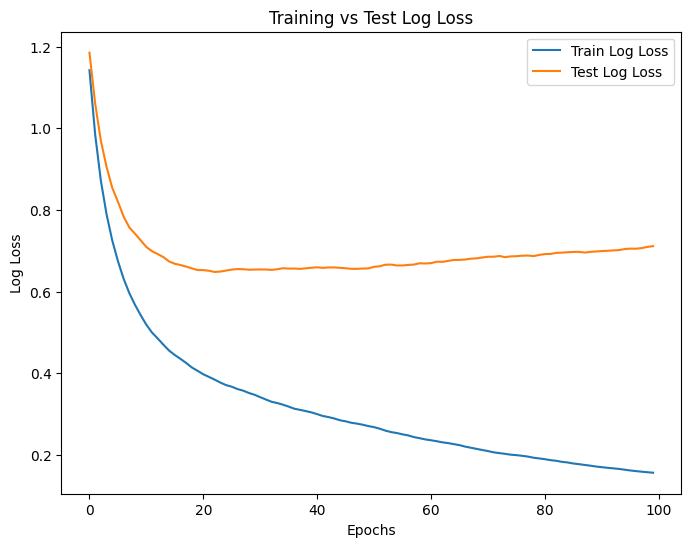

Test Accuracy: 0.7219


In [12]:
# Define parameter grid for XGBoost
param_grid = {
    "max_depth": [2, 3, 5], 
    "learning_rate": [0.1, 0.05, 0.25],
    "reg_lambda": [1, 5, 100], 
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    scale_pos_weight=1.0,  # Adjust based on class imbalance ratio if known
    tree_method='hist',  # Faster training with histogram-based method
    enable_categorical=False  # Ensure compatibility with features
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    scoring='accuracy'  # Optimize for accuracy directly
)

# Train model with cross-validation
# grid_search.fit(X, y)
grid_search.fit(X_res, y_res)

# Get the best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


# Train with early stopping on the full dataset
history = best_model.fit(
    X_res,
    y_res,
    eval_set=[(X_res, y_res), (X_test, y_test)],

    verbose=True
)

# Plot training and test accuracy
eval_results = best_model.evals_result()
epochs = range(len(eval_results['validation_0']['mlogloss']))
train_loss = eval_results['validation_0']['mlogloss']
test_loss = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Train Log Loss')
plt.plot(epochs, test_loss, label='Test Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Log Loss')
plt.legend()
plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V7_optimized_loss_plot.png")))
plt.show()

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7218543046357616
Test Precision: 0.722348460144766
Test Recall: 0.7218543046357616
Test F1 Score: 0.7207308950672304
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        97
           1       0.68      0.61      0.64        77
           2       0.65      0.76      0.70        51
           3       0.81      0.83      0.82        77

    accuracy                           0.72       302
   macro avg       0.72      0.73      0.72       302
weighted avg       0.72      0.72      0.72       302

Saved model to: ..\output\XGBoost\model\XGB_model_v7.joblib
Best Cross-Validation Accuracy: 93.66%


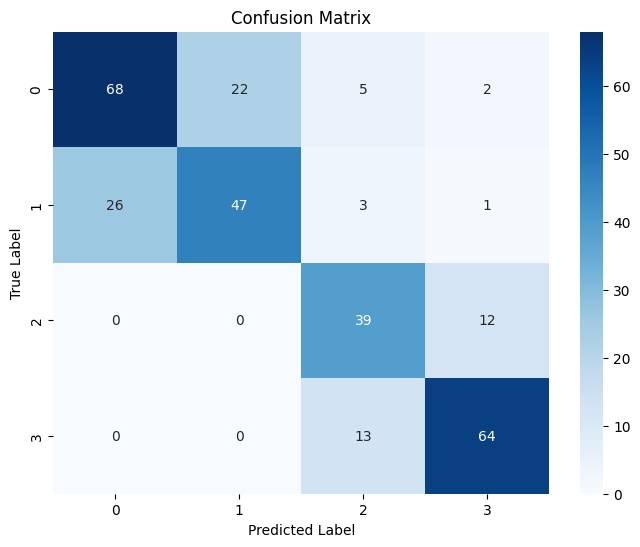

In [13]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V7_confusion_matrix.png"))) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
XGB_model_v5 = Path(os.path.join(output_model_dir, "XGB_model_v7.joblib"))
joblib.dump(best_model, XGB_model_v5)
print(f"Saved model to: {XGB_model_v5}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")